In [1]:
import pandas as pd
import numpy as np

import itertools
import random
from math import sqrt
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler #Scaling for better performance

In [2]:
df = pd.read_csv('Jacksonville KPI 2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')

#Differencing the 'Actual Trips' column due to a p_value greater than 0.05
df['Turn Down Transports Diff']=df['Turn Down Transports'].diff()

#Dropping the NaN values resulting from differencing
df.dropna(inplace = True)

pd.DataFrame(df)

,Actual Trips,Operating Hours,Turn Down Transports,Turn Down Transports Diff
Date of Service,,,,
2023-01-03,5.0,14.16,5.0,5.0
2023-01-04,4.0,21.16,2.0,-3.0
2023-01-05,11.0,39.12,6.0,4.0
2023-01-06,9.0,21.65,4.0,-2.0
2023-01-07,8.0,30.07,1.0,-3.0
...,...,...,...,...
2024-01-10,19.0,53.55,8.0,-9.0
2024-01-11,11.0,27.25,3.0,-5.0
2024-01-12,23.0,55.77,8.0,5.0


In [3]:
#Using the Dickery-Fuller test, testing 'Actual Trips Diff' for stationary
result_diff = adfuller(df['Turn Down Transports']) #Testing with no Diff
#result_diff = adfuller(df['Turn Down Transports Diff'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value %f' % result_diff[1])

ADF Statistic: -5.467530
p-value 0.000002


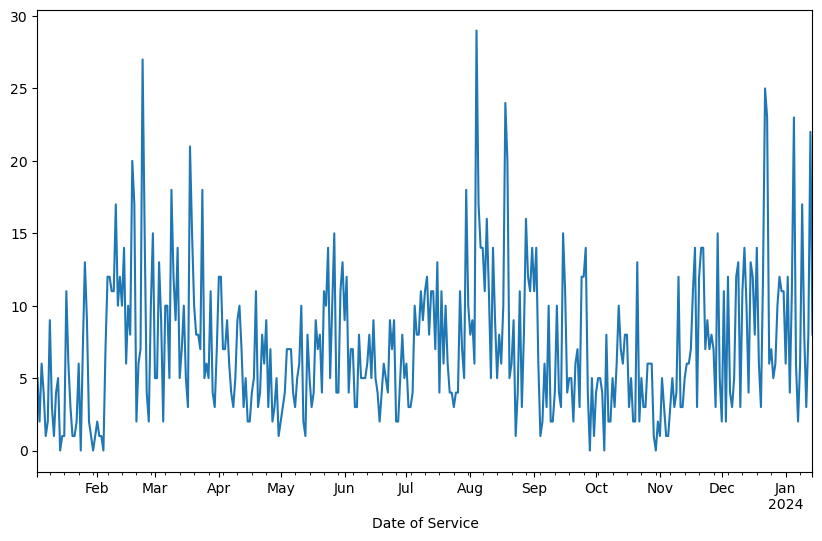

In [4]:
#Visualizing the Differenced Series
df['Turn Down Transports'].plot(figsize=(10,6))
plt.show()

In [5]:
# #Train-Test Split
# train_end = pd.to_datetime('11/30/2023') #End-Date for training, not for entire dataset
# train = df.loc[:train_end]
# test = df.loc[train_end + pd.Timedelta(days=1):] #The rest of the dates
# #pd.DataFrame(train)
# pd.DataFrame(test)

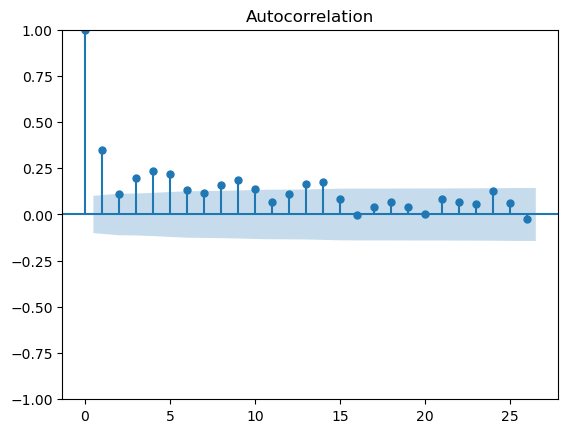

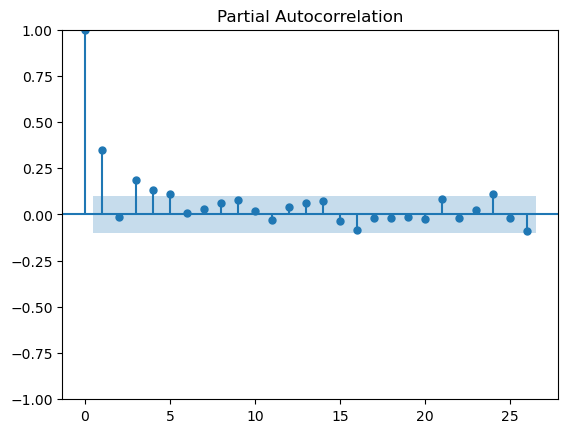

In [6]:
#Using grid search for model selection. (Still needs to be implemented)
plot_acf(df['Turn Down Transports'].dropna())
plot_pacf(df['Turn Down Transports'].dropna())
plt.show()

In [7]:
#Defining Parameter Space
# p = d = q = range(0,3)
# P = D = Q = range(0, 3)
# s_values = [7, 14, 30]  #Testing for Weekly, Bi-Weely, and Monthly Seasonality

#Narrowing selection based on emperical evidence from testing
p = range(1,2)
d = q = range(0,3)
P = D = Q = range(0,3)
s_values = [7, 14, 30, 60]

# Random Grid Search across all units
#pdq_combinations = list(itertools.product(p,d,q))
#seasonal_combinations = [(x[0], x[1], x[2], s) for x in list(itertools.product(P,D,Q)) for s in s_values]

# Random Grid Search across all units
parameters = list(itertools.product(p, d, q, P, D, Q, s_values))
pdq_combinations = random.sample(parameters, min(len(parameters), 1))  # Randomly sample combinations to list of 10.
#If not, then there would be a huge list to try out and it just takes too long. That's why the previous 2 lines of code take 
#a long time to finish. Need a stronger PC to run. Meanwhile, Keep running these 2 lines until you get a low AIC. 

In [8]:
#To illistrate the difference in the size of each list. 
pdq_combinations

[(1, 2, 2, 0, 2, 2, 7)]

In [9]:
#Testing specific parameters. 
pdq_combinations.extend(((1, 0, 1, 0, 2, 2, 30), (1, 0, 0, 2, 1, 0, 30), (1, 0, 2, 1, 2, 2, 60))) #(1, 2, 2, 1, 2, 2, 60) Not well when generalizing
pdq_combinations

[(1, 2, 2, 0, 2, 2, 7),
 (1, 0, 1, 0, 2, 2, 30),
 (1, 0, 0, 2, 1, 0, 30),
 (1, 0, 2, 1, 2, 2, 60)]

In [10]:
#Grid Search Function that returns lowest AIC

#A lot to compute
#def sarimax_grid_search(data, exog_data, pdq_combinations, seasonal_combinations): #Order and seasonal order separated.
    
#Less to compute
def sarimax_grid_search(data, exog_data, pdq_combinations): #Aggregated order and seasonal order. 
#def sarimax_grid_search(data, pdq_combinations): #Testing without exogenous values
    best_aic = float("inf")
    best_configuration = None
    best_model = None

    #Used for training/test split further below. 
    split_date = pd.Timestamp('2023-11-15')
    
    #Training Test Split
    train = data[data.index < split_date]
    test = data[data.index >= split_date]

    train_exog = exog_data[exog_data.index < split_date]
    test_exog = exog_data[exog_data.index >= split_date]
    
    #For lesser computers.
    for pdq in pdq_combinations:
        try:
            model = SARIMAX(train, order=pdq[:3], seasonal_order=pdq[3:], exog = train_exog, 
                            enforce_stationarity=True, enforce_invertibility=True)
            model_fit = model.fit(disp=False)

            if model_fit.aic < best_aic: #Depending on what for loop block, we need to indent.
                best_aic = model_fit.aic
                #best_configuration = (pdq, seasonal_combination)
                best_configuration = pdq
                best_model = model_fit

        except Exception as e: #Depending on what for loop block, we need to indent.
            print(e)
            continue
            
    if best_configuration is None:
        raise ValueError("No suitable model parameters found for aggregate data")
    
    #Predicting the rest of the forecast to compare to test data. Steps has to be the remaining days to predict. 
    predictions = best_model.forecast(steps=len(test), exog = test_exog)
    
    # Performance Metrics
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mse)
    print(f'Best SARIMAX: {best_configuration} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

    # Plotting Forecast vs Actual
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions, label='Forecast', color='red')
    plt.title(f'SARIMAX Model Forecast vs Operating Hours')
    plt.xlabel('Date')
    plt.ylabel('Operating Hours')
    plt.legend()
    plt.show()
    
    return best_aic, best_configuration, best_model

In [11]:
#Preparing data with proper frequency and scaling
features_to_normalize = ['Actual Trips', 'Operating Hours', 'Turn Down Transports']
scaler = StandardScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
#df

start_date = df.index.min()
end_date = df.index.max()
date_range = pd.date_range(start= start_date, end= end_date, freq = 'D')
data = df[['Actual Trips', 'Operating Hours', 'Turn Down Transports']].groupby(df.index).mean().reindex(date_range, 
                                                                                                        fill_value = 0)
data

,Actual Trips,Operating Hours,Turn Down Transports
2023-01-03,-1.241834,-1.349236,-0.456949
2023-01-04,-1.416721,-0.891697,-1.071468
2023-01-05,-0.192514,0.282216,-0.252110
2023-01-06,-0.542288,-0.859670,-0.661789
2023-01-07,-0.717174,-0.309316,-1.276307
...,...,...,...
2024-01-10,1.206579,1.225399,0.157569
2024-01-11,-0.192514,-0.493639,-0.866628
2024-01-12,1.906125,1.370504,0.157569
2024-01-13,0.157259,-0.734173,3.025320


C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  w

Best SARIMAX: (1, 0, 2, 1, 2, 2, 60) - MSE: 2.209452042209244, MAE: 1.2062315742864445, RMSE: 1.4864225651574468


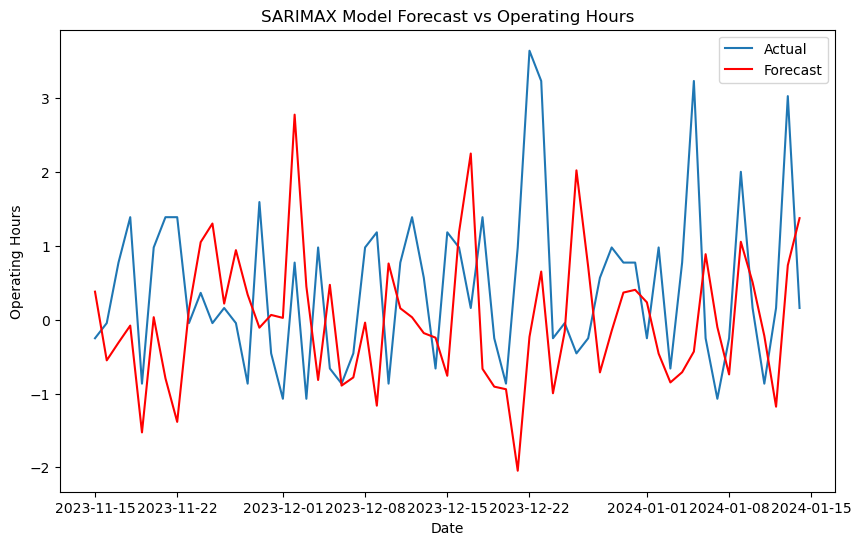

In [12]:
#Running Grid Search
#SARIMAX can internally difference with value (d). We manually difference (d=1) just to check stationarity. 
#Now we will let SARIMAX integrate difference by setting d=1 manually on the ORIGINAL dataset. 

#ts_data = df['Turn Down Transports'] #No scaling, we are more concerned with stationarity with the target value. 

ts_data = data['Turn Down Transports'] #Scaling is being performed on actual trips as well for better performance.

#Exogenous Values tend to help the model significantly.
exog = data[['Actual Trips', 'Operating Hours']]

#For lesser PC
best_aic, best_configuration, best_model = sarimax_grid_search(ts_data, exog, pdq_combinations)

# print(f"Best SARIMAX parameters: {best_configuration} with AIC: {best_aic}")

In [13]:
#Best SARIMAX: (1, 0, 2, 1, 2, 2, 60) - MSE: 2.99353096268169, MAE: 1.36194601836220, RMSE: 1.73018234954633 Generalize Better!!
#Best SARIMAX: (1, 0, 1, 0, 2, 2, 30) - MSE: 2.0087577308475675, MAE: 1.092793991672091, RMSE: 1.4173065056111072
best_configuration

(1, 0, 2, 1, 2, 2, 60)

In [14]:
sarimax_model = SARIMAX(ts_data,
               order = best_configuration[:3],
               seasonal_order = best_configuration[3:])
               #exog=exog) #Comment out to test without exogenout values
    
sarimax_model_fit = sarimax_model.fit(disp=False)

C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
#model = best_model
model = sarimax_model_fit
steps = 14
forecast = model.forecast(steps)  # Forecasting for the next 14 day

In [16]:
forecast

2024-01-15    0.091319
2024-01-16    1.292185
2024-01-17    1.515639
2024-01-18   -1.130442
2024-01-19    1.315795
2024-01-20    1.357811
2024-01-21    0.731059
2024-01-22    0.434041
2024-01-23    1.630708
2024-01-24    1.412220
2024-01-25    0.379309
2024-01-26    0.126159
2024-01-27   -0.376685
2024-01-28    1.198055
Freq: D, Name: predicted_mean, dtype: float64

In [17]:
#To correctly apply the inverse transform, you need to reconstruct an array that matches the original data's shape.
original_data = pd.read_csv('Jacksonville KPI 2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')

#Dropping the NaN values resulting from differencing
original_data.dropna(inplace = True)

#Creating dummy array with zeroes that has same shape as original dataset
dummy_array = np.zeros((len(forecast), original_data.shape[1]))

#Replace column for target variable in the dummy array with your predicitons
dummy_array[:, 2] = forecast
dummy_array

array([[ 0.        ,  0.        ,  0.09131862],
       [ 0.        ,  0.        ,  1.29218547],
       [ 0.        ,  0.        ,  1.51563928],
       [ 0.        ,  0.        , -1.13044182],
       [ 0.        ,  0.        ,  1.3157948 ],
       [ 0.        ,  0.        ,  1.35781069],
       [ 0.        ,  0.        ,  0.73105888],
       [ 0.        ,  0.        ,  0.43404139],
       [ 0.        ,  0.        ,  1.63070809],
       [ 0.        ,  0.        ,  1.41222024],
       [ 0.        ,  0.        ,  0.37930912],
       [ 0.        ,  0.        ,  0.12615877],
       [ 0.        ,  0.        , -0.37668545],
       [ 0.        ,  0.        ,  1.1980554 ]])

In [18]:
#Apply inverse transform
inverse_array = scaler.inverse_transform(dummy_array)

#Extracting the target variable predictions from inverse transform array
predicted_TDT = inverse_array[:, 2] #Positioning matters as it needs correct inverse values for each column. 

predicted_TDT

array([ 7.67657514, 13.53905499, 14.62992819,  1.71209548, 13.65431279,
       13.85942903, 10.79970607,  9.34970434, 15.19167957, 14.12504955,
        9.08250831,  7.84666034,  5.39183858, 13.07952395])

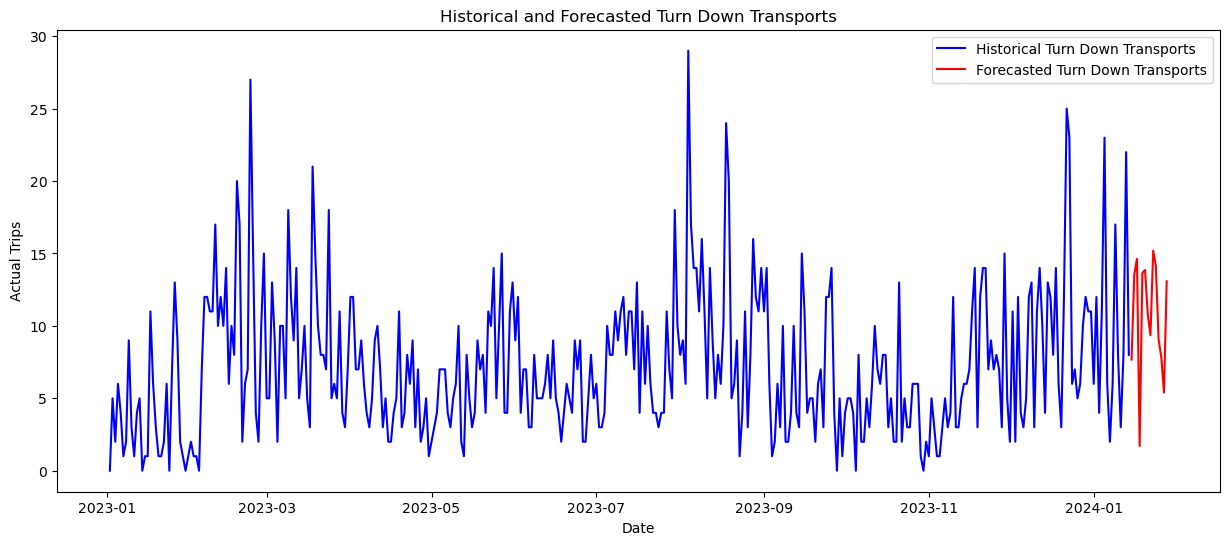

In [19]:
#Visualizing Forecast Alongside Historical Data

#Historical Values
plt.figure(figsize=(15,6))
plt.plot(original_data.index, original_data['Turn Down Transports'], label='Historical Turn Down Transports', color = 'blue')

#Forecasted Values
future_dates = pd.date_range(start=original_data.index[-1] + pd.Timedelta(days=1), periods=14, freq = 'D')
plt.plot(future_dates, predicted_TDT, label = 'Forecasted Turn Down Transports', color = 'red')

#Setting Title and Labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Actual Trips')
plt.title('Historical and Forecasted Turn Down Transports')

#Save Figure
plt.savefig('Turn Down Transports Forecasted Trajectory.pdf', bbox_inches='tight')

plt.show()

In [20]:
#Storing predictions in a DataFrame
forecast_df = pd.DataFrame({'Date of Service': future_dates.strftime('%A: %m-%d-%Y'),
                            'Turn Down Transports': predicted_TDT})
forecast_df = forecast_df.round(0)
forecast_df #Might be best to test without exogenous values. Operating Hours looks to be independent from other variables.
#So far it looks like exog values are best used for training only. 

,Date of Service,Turn Down Transports
0,Monday: 01-15-2024,8.0
1,Tuesday: 01-16-2024,14.0
2,Wednesday: 01-17-2024,15.0
3,Thursday: 01-18-2024,2.0
4,Friday: 01-19-2024,14.0
5,Saturday: 01-20-2024,14.0
6,Sunday: 01-21-2024,11.0
7,Monday: 01-22-2024,9.0
8,Tuesday: 01-23-2024,15.0
9,Wednesday: 01-24-2024,14.0


In [21]:
#Saving DataFrame to a csv file
forecast_df.to_csv('3. Turn Down Transports Predictions - Jacksonville.csv', mode = 'w', index = False, header = True)